In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./dl-assets-pricing")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

from preprocess_data import next_month, Dataset, train_val_split, batchify
from train import trainmodel, check_accuracy
from losses import pricing_error, time_series_variation
from torch.utils.data.dataloader import DataLoader
from fama_french_helper import ff_returns
from metrics import compute_Rts, compute_PE, compute_CS 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from model import DeepCharacteristics, SortedFactorModel

In [3]:
ff_factors_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/fama_french_factors.csv'
ff_ptf_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios.csv'
firm_carac = pd.read_csv("C:/Users/Raach/Desktop/3A/Projet MDS/S2000_3300HighestCap.csv")
firm_carac["be"] = firm_carac["be"]*1e6
ff_portfolio = pd.read_csv(ff_ptf_file)
ff_portfolio = ff_portfolio[ff_portfolio["date"].notnull()]
fff = pd.read_csv(ff_factors_file)
for df in [firm_carac,
           ff_portfolio,
           fff]:
        if type(df["date"].iloc[0]) == str:
            df["date"] = df["date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
        df["date"] = df["date"].apply(lambda x: x.replace(day=1))

In [4]:
firm_carac["be"] = firm_carac["be"] / 1e9
firm_carac["me"] = firm_carac["me"] / 1e9
firm_carac["BtM"] = firm_carac["be"]/firm_carac["me"]

In [5]:
current_month = dt.datetime(2000, 1, 1)
start_date = current_month
firm_characteristics = []
firm_returns = []
benchmark_factors = []
portfolios_returns = []
while current_month <= dt.datetime(2021, 12, 31):
    m_fc = firm_carac[(firm_carac["date"] == current_month) & (firm_carac["is_valid"])
                      ].sort_values("me", ascending=False).iloc[:2300]
    assert len(m_fc) == 2300
    firm_characteristics.append(m_fc[["retx", "me", "be"]].to_numpy())
    firm_returns.append(m_fc["retx"].to_numpy())
    benchmark_factors.append(fff[fff["date"] == current_month][["mktrf", "smb", "hml", "rf"]].to_numpy())
    portfolios_returns.append((ff_portfolio[ff_portfolio["date"] == current_month][[
                              k for k in ff_portfolio.keys() if "vwret" in k]]).to_numpy())
    current_month = next_month(current_month)
current_month = current_month-dt.timedelta(1)
firm_characteristics = np.stack(firm_characteristics)
firm_returns = np.stack(firm_returns)
benchmark_factors = np.stack(benchmark_factors).squeeze(axis=1)
portfolios_returns = np.stack(portfolios_returns).squeeze(axis=1)
portfolios_excess_returns = portfolios_returns - benchmark_factors[:,-1][:, None]
ds = Dataset(firm_characteristics[:, :, [1, 2]], firm_returns, benchmark_factors[:, [0, 2]], portfolios_excess_returns, start_date=start_date, end_date=current_month)

In [6]:
ptf_dict = ff_returns(ff_ptf_file, ff_factors_file, start_date, current_month, factors=["mktrf", "hml"])
ff3_coefs = pd.DataFrame.from_dict(ptf_dict)

In [22]:
ff3_coefs

,smlo,smme,smhi,bilo,bime,bihi
const,-0.001305,0.002842,0.005165,0.001042,0.001865,0.000169
mktrf,1.436448,1.156232,1.111091,1.172560,1.061834,1.211756
hml,-0.430999,0.190790,0.420701,-0.200569,0.446377,0.786664


In [7]:
train_set, val_set = train_val_split(ds)
batch_size = 5
trainloader = batchify(train_set, batch_size)
valloader = batchify(val_set, batch_size)

Validation data on time range: 2017-09-01 to 2021-12-31


In [23]:
lambda_ = 10
def loss(gt_returns, pred_returns):
        return lambda_ * pricing_error(gt_returns, pred_returns) + time_series_variation(gt_returns, pred_returns)

In [24]:
network = SortedFactorModel(2, 2, 4, n_deep_factors=1, n_BM_factors=2, n_portfolio=6, ranking_method="softmax")

In [25]:
network, train_loss, val_loss = trainmodel(network, loss, trainloader, valloader, None, None, 20, weight_decay=0.1,
               loss_every=5, learning_rate=0.001)

Epoch     0/   20, loss = -1.0000, val_loss = 0.020499


 25%|██████████████████████████████████████                                                                                                                  | 5/20 [00:11<00:35,  2.33s/it]

Epoch     5/   20, loss = 0.007483, val_loss = 0.010412


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 10/20 [00:26<00:28,  2.86s/it]

Epoch    10/   20, loss = 0.003656, val_loss = 0.005422


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15/20 [00:42<00:15,  3.16s/it]

Epoch    15/   20, loss = 0.001718, val_loss = 0.002544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.98s/it]

Epoch    20/   20, loss = 0.000781, val_loss = 0.000926


In [26]:
data = batchify(val_set, len(val_set))[0]
Z, r, g, R = data
R_p, f = network.forward(Z, r, g)
g = g.detach().numpy()
betas = torch.concat([network.gamma, network.beta], axis=1)

In [27]:
print(f"Time series R: {compute_Rts(R, R_p):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_p)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, betas)}")

Time series R: 0.94114
Pricing error PE (1e-5): 0.34105
Cross sectional R: 0.9383722771058303


In [28]:
g_aug = np.concatenate([np.ones([g.shape[0], 1]), g], axis=1)
R_2f = g_aug @ ff3_coefs.to_numpy()
    

In [29]:
print(f"Time series R: {compute_Rts(R, R_2f):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_2f)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, ff3_coefs.to_numpy().T)}")

Time series R: 0.86222
Pricing error PE (1e-5): 3.28411
Cross sectional R: 0.9328430757685438


In [30]:
from scipy.stats import pearsonr

In [31]:
f_pred = f.detach().numpy().reshape(-1)
f_gt = benchmark_factors[-len(val_set):, 1]
pearsonr(f_gt, f_pred)

(0.8773410532954022, 3.047082119926187e-17)

In [32]:
network.beta

Parameter containing:
tensor([[ 0.6266],
        [ 0.6105],
        [ 0.6166],
        [-0.2407],
        [ 0.0153],
        [ 0.0806]], requires_grad=True)

Text(0, 0.5, 'Predicted SMB')

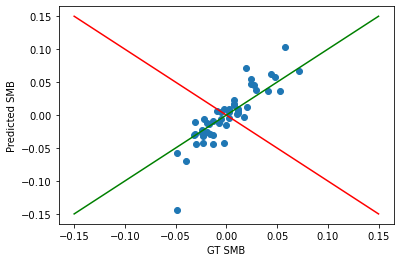

In [33]:
plt.scatter(f_gt, f_pred)
plt.plot([-0.15,0.15], [0.15,-0.15], color='r')
plt.plot([-0.15,0.15], [-0.15,0.15], color='g')

plt.xlabel("GT SMB")
plt.ylabel("Predicted SMB")

In [34]:
x = torch.abs((R_p-R)/R).flatten().detach().numpy() * 100
x = x[x<200]

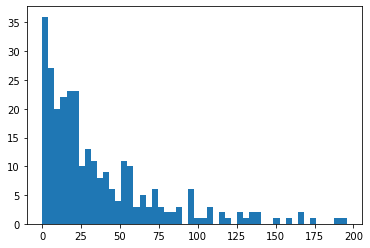

In [35]:
h, b, _ = plt.hist(x, bins=50)

In [36]:
np.median(x)

22.400393

In [37]:
pdf = h/h.sum()

In [38]:
cdf = np.cumsum(pdf)

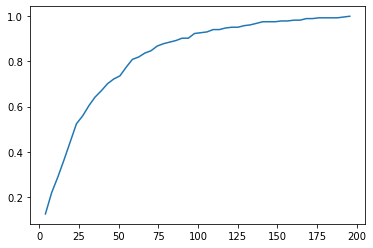

In [39]:
plt.plot(b[1:], cdf)